Project 2:  Time Series Forecasting using NN, LSTM and CNN 

CSC 215 Artificial Intelligence (Spring 2023)

Raul Arambula and Bashar Allwza

In [1]:
%matplotlib inline
%load_ext tensorboard
import pandas as pd
import numpy as np
import math
import datetime
from matplotlib import pyplot
from collections.abc import Sequence
from scipy.stats import zscore
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import imblearn

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [3]:
#Import Apple stock data
stock = pd.read_csv("AAPL.csv") 

In [4]:
# Clear any logs from previous runs
!rd /s /q "logs"
#!rm -rf ./logs/ 

In [5]:
stock.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10634,2023-02-16,153.509995,156.330002,153.350006,153.710007,153.710007,68167900
10635,2023-02-17,152.350006,153.000000,150.850006,152.550003,152.550003,59095900
10636,2023-02-21,150.199997,151.300003,148.410004,148.479996,148.479996,58867200
10637,2023-02-22,148.869995,149.949997,147.160004,148.910004,148.910004,51011300
10638,2023-02-23,150.089996,150.339996,147.240005,149.399994,149.399994,48394200


In [6]:
#drop unnecessary columns and rows, also duplicated 'Close' column
stock = stock.drop(columns=['Date','Adj Close'], axis=1)
stock_more = stock.copy()
stock = stock.iloc[-7:]
stock['Close Dup'] = stock.loc[:, 'Close']
stock

,Open,High,Low,Close,Volume,Close Dup
10632,152.119995,153.770004,150.860001,153.199997,61707600,153.199997
10633,153.110001,155.500000,152.880005,155.330002,65669300,155.330002
10634,153.509995,156.330002,153.350006,153.710007,68167900,153.710007
10635,152.350006,153.000000,150.850006,152.550003,59095900,152.550003
10636,150.199997,151.300003,148.410004,148.479996,58867200,148.479996
10637,148.869995,149.949997,147.160004,148.910004,51011300,148.910004
10638,150.089996,150.339996,147.240005,149.399994,48394200,149.399994


In [7]:
#normalization of data
encode_numeric_zscore(stock, 'Open')
encode_numeric_zscore(stock, 'High')
encode_numeric_zscore(stock, 'Low')
encode_numeric_zscore(stock, 'Close')
encode_numeric_zscore(stock, 'Volume')
stock

,Open,High,Low,Close,Volume,Close Dup
10632,0.375201,0.356162,0.294878,0.573289,0.377078,153.199997
10633,0.941687,1.051823,1.086074,1.363288,0.926300,155.330002
10634,1.170565,1.385580,1.270165,0.762447,1.272689,153.710007
10635,0.506814,0.046531,0.290963,0.332213,0.015010,152.550003
10636,-0.723430,-0.637067,-0.664738,-1.177314,-0.016695,148.479996
10637,-1.484463,-1.179927,-1.154339,-1.017828,-1.105783,148.910004
10638,-0.786373,-1.023102,-1.123004,-0.836095,-1.468599,149.399994


In [8]:
x,y = to_xy(stock,"Close Dup")
print(x.shape,y.shape)
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7, 5) (7,)
(4, 5) (4,)
(3, 5) (3,)


Full-Connected Neural Network Based on Last 7 Days

In [9]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    nn_model = Sequential()
    
    nn_model.add(Dense(250, input_dim = x.shape[1], activation='relu')) # Hidden 1
    nn_model.add(Dense(150, activation = 'relu')) # Hidden 2 
    nn_model.add(Dense(75, activation = 'relu')) # Hidden 3 
    nn_model.add(Dense(50, activation='relu')) # Hidden 4 
    nn_model.add(Dense(20, activation='relu')) # Hidden 5 
    nn_model.add(Dense(10, activation = 'relu')) # Hidden 6 
    nn_model.add(Dense(1)) # Output

    nn_model.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto') 

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    nn_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer,tensorboard_callback], verbose=2, epochs=100) 

nn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model

nn_pred = nn_model.predict(x_test)

Epoch 1/100
1/1 - 0s - loss: 22786.4102 - mean_absolute_error: 150.9357 - val_loss: 23202.4453 - val_mean_absolute_error: 152.2989
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 - 0s - loss: 22762.2207 - mean_absolute_error: 150.8554 - val_loss: 23176.0410 - val_mean_absolute_error: 152.2115
Epoch 3/100
1/1 - 0s - loss: 22735.9980 - mean_absolute_error: 150.7682 - val_loss: 23142.5996 - val_mean_absolute_error: 152.1008
Epoch 4/100
1/1 - 0s - loss: 22705.3477 - mean_absolute_error: 150.6662 - val_loss: 23103.1816 - val_mean_absolute_error: 151.9704
Epoch 5/100
1/1 - 0s - loss: 22670.1602 - mean_absolute_error: 150.5491 - val_loss: 23056.9551 - val_mean_absolute_error: 151.8174
Epoch 6/100
1/1 - 0s - loss: 22631.4492 - mean_absolute_error: 150.4201 - val_loss: 23005.9297 - val_mean_absolute_error: 151.6484
Epoch 7/100
1/1 - 0s - loss: 22587.1172 - mean_absolute_error: 150.2722 - val_loss: 22949.3066 - val_mean_absolute_error: 151.4605
Epoch 8/100

In [10]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(nn_pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 46.87528991699219


In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:40:41 ago. (Use '!kill 4332' to kill it.)

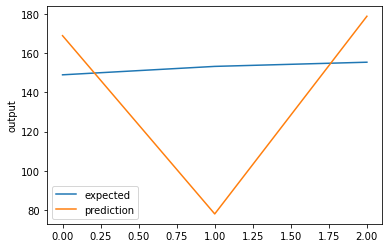

In [12]:
# Regression Lift Chart
chart_regression(nn_pred.flatten(),y_test,sort=True)

LSTM Model Based on Last 7 Days

In [13]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train - The directory is not empty.
./logs/\fit\202303~1\VALIDA~1 - The directory is not empty.
./logs/\fit\202303~2\train - The directory is not empty.
./logs/\fit\202303~2\VALIDA~1 - The directory is not empty.
./logs/\fit\202303~3\train - The directory is not empty.
./logs/\fit\202303~3\VALIDA~1 - The directory is not empty.
./logs/\fit\202303~4\train - The directory is not empty.
./logs/\fit\202303~4\VALIDA~1 - The directory is not empty.
./logs/\fit\20CA20~1\train - The directory is not empty.
./logs/\fit\20CA20~1\VALIDA~1 - The directory is not empty.


In [14]:
SEQUENCE_SIZE = 5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (4, 5, 1)
Shape of x_test: (3, 5, 1)
Shape of y_train: (4,)
Shape of y_test: (3,)


In [15]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    lstm_model = Sequential()

    lstm_model.add(LSTM(128, input_shape=(SEQUENCE_SIZE, 1), return_sequences=True))
    lstm_model.add(LSTM(64, return_sequences=True))
    lstm_model.add(LSTM(32, return_sequences=True))
    lstm_model.add(LSTM(16, return_sequences=False))
    lstm_model.add(Dense(64, activation='relu'))
    lstm_model.add(Dense(32, activation='relu'))
    lstm_model.add(Dense(16, activation='relu'))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    lstm_model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2, epochs=100)  

lstm_model.load_weights('lstm/best_weights.hdf5') # load weights from best model

lstm_pred = lstm_model.predict(x_test)

Epoch 1/100
1/1 - 1s - loss: 22816.6465 - mean_absolute_error: 151.0364 - val_loss: 23256.7402 - val_mean_absolute_error: 152.4782
Epoch 2/100
1/1 - 0s - loss: 22815.6562 - mean_absolute_error: 151.0331 - val_loss: 23255.4902 - val_mean_absolute_error: 152.4741
Epoch 3/100
1/1 - 0s - loss: 22814.4219 - mean_absolute_error: 151.0290 - val_loss: 23253.9434 - val_mean_absolute_error: 152.4690
Epoch 4/100
1/1 - 0s - loss: 22812.8691 - mean_absolute_error: 151.0238 - val_loss: 23252.2949 - val_mean_absolute_error: 152.4636
Epoch 5/100
1/1 - 0s - loss: 22811.2344 - mean_absolute_error: 151.0184 - val_loss: 23250.5859 - val_mean_absolute_error: 152.4581
Epoch 6/100
1/1 - 0s - loss: 22809.5332 - mean_absolute_error: 151.0128 - val_loss: 23248.8145 - val_mean_absolute_error: 152.4522
Epoch 7/100
1/1 - 0s - loss: 22807.7812 - mean_absolute_error: 151.0070 - val_loss: 23246.9707 - val_mean_absolute_error: 152.4462
Epoch 8/100
1/1 - 0s - loss: 22805.9453 - mean_absolute_error: 151.0009 - val_loss:

In [16]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 2.961571216583252


In [17]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:45:20 ago. (Use '!kill 4332' to kill it.)

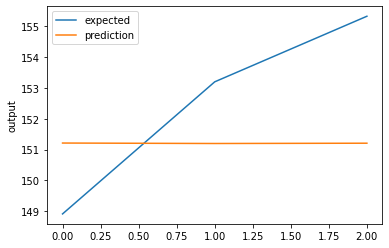

In [18]:
# Regression Lift Chart
chart_regression(lstm_pred.flatten(),y_test,sort=True)

CNN Model Based on Last 7 Days

In [19]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [20]:
# Define batch_size
batch_size = 128

In [21]:
# define input image dimensions
img_rows, img_cols = 5, 1

In [22]:
x_train = x_train.reshape(x_train.shape[0], 5, 1, 1)
x_test = x_test.reshape(x_test.shape[0], 5, 1, 1)
print(x_train.shape)
print(x_test.shape)

(4, 5, 1, 1)
(3, 5, 1, 1)


In [23]:
x_train.dtype

dtype('float32')

In [24]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    cnn_model = Sequential()

    input_shape = (5, 1, 1)

    cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                    activation='relu',
                    input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)
    cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model.add(Conv2D(32, kernel_size=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model.add(Conv2D(16, kernel_size=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model.add(Conv2D(8, kernel_size=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1))

    cnn_model.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=100, verbose=2, 
                  validation_data=(x_test, y_test),callbacks=[monitor, checkpointer,tensorboard_callback])

cnn_model.load_weights('cnn/best_weights.hdf5') # load weights from best model

cnn_pred = cnn_model.predict(x_test)

Epoch 1/100
1/1 - 0s - loss: 22817.1270 - mean_absolute_error: 151.0379 - val_loss: 23249.6172 - val_mean_absolute_error: 152.4549
Epoch 2/100
1/1 - 0s - loss: 22808.3945 - mean_absolute_error: 151.0090 - val_loss: 23241.0840 - val_mean_absolute_error: 152.4268
Epoch 3/100
1/1 - 0s - loss: 22800.4531 - mean_absolute_error: 150.9826 - val_loss: 23231.5527 - val_mean_absolute_error: 152.3955
Epoch 4/100
1/1 - 0s - loss: 22791.5703 - mean_absolute_error: 150.9532 - val_loss: 23220.8223 - val_mean_absolute_error: 152.3602
Epoch 5/100
1/1 - 0s - loss: 22781.8906 - mean_absolute_error: 150.9211 - val_loss: 23208.9395 - val_mean_absolute_error: 152.3211
Epoch 6/100
1/1 - 0s - loss: 22770.9492 - mean_absolute_error: 150.8848 - val_loss: 23195.2793 - val_mean_absolute_error: 152.2762
Epoch 7/100
1/1 - 0s - loss: 22758.3164 - mean_absolute_error: 150.8428 - val_loss: 23179.2012 - val_mean_absolute_error: 152.2233
Epoch 8/100
1/1 - 0s - loss: 22743.5039 - mean_absolute_error: 150.7937 - val_loss:

In [25]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(cnn_pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 33.031734466552734


In [26]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:48:28 ago. (Use '!kill 4332' to kill it.)

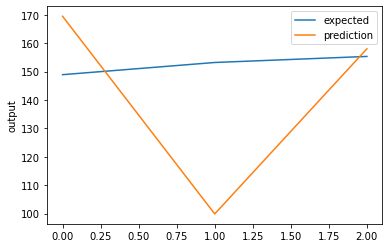

In [27]:
# Regression Lift Chart
chart_regression(cnn_pred.flatten(),y_test,sort=True)

LSTM Model With Bidirectional and Attention Layers Based on Last 7 Days

In [28]:
%pip install attention
from attention import Attention

Note: you may need to restart the kernel to use updated packages.


In [29]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [30]:
SEQUENCE_SIZE = 5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (4, 5, 1)
Shape of x_test: (3, 5, 1)
Shape of y_train: (4,)
Shape of y_test: (3,)


In [31]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    lstm_model = Sequential()

    lstm_model.add(Bidirectional(LSTM(128, input_shape=(SEQUENCE_SIZE, 1), return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(16, return_sequences=True)))
    lstm_model.add(Attention(units=16))
    lstm_model.add(Dense(64, activation='relu'))
    lstm_model.add(Dense(32, activation='relu'))
    lstm_model.add(Dense(16, activation='relu'))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    lstm_model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2, epochs=100)  

lstm_model.load_weights('lstm/best_weights.hdf5') # load weights from best model

lstm_pred = lstm_model.predict(x_test)

Epoch 1/100
1/1 - 2s - loss: 22817.0586 - mean_absolute_error: 151.0377 - val_loss: 23253.6875 - val_mean_absolute_error: 152.4682
Epoch 2/100
1/1 - 0s - loss: 22813.0508 - mean_absolute_error: 151.0245 - val_loss: 23250.4395 - val_mean_absolute_error: 152.4576
Epoch 3/100
1/1 - 0s - loss: 22810.1621 - mean_absolute_error: 151.0149 - val_loss: 23246.7559 - val_mean_absolute_error: 152.4456
Epoch 4/100
1/1 - 0s - loss: 22806.9883 - mean_absolute_error: 151.0045 - val_loss: 23242.5254 - val_mean_absolute_error: 152.4317
Epoch 5/100
1/1 - 0s - loss: 22803.0840 - mean_absolute_error: 150.9916 - val_loss: 23237.5449 - val_mean_absolute_error: 152.4154
Epoch 6/100
1/1 - 0s - loss: 22798.4434 - mean_absolute_error: 150.9762 - val_loss: 23231.9922 - val_mean_absolute_error: 152.3972
Epoch 7/100
1/1 - 0s - loss: 22793.3477 - mean_absolute_error: 150.9594 - val_loss: 23225.6582 - val_mean_absolute_error: 152.3764
Epoch 8/100
1/1 - 0s - loss: 22787.6836 - mean_absolute_error: 150.9407 - val_loss:

In [32]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 39.54289245605469


In [33]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:51:38 ago. (Use '!kill 4332' to kill it.)

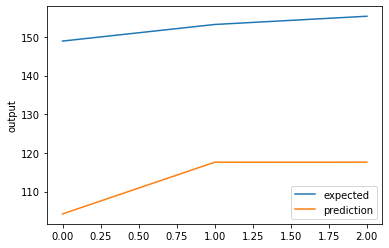

In [34]:
# Regression Lift Chart
chart_regression(lstm_pred.flatten(),y_test,sort=True)

Last 548 Days of Stock Data

In [35]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [36]:
stock_more

,Open,High,Low,Close,Volume
0,0.128348,0.128906,0.128348,0.128348,469033600
1,0.122210,0.122210,0.121652,0.121652,175884800
2,0.113281,0.113281,0.112723,0.112723,105728000
3,0.115513,0.116071,0.115513,0.115513,86441600
4,0.118862,0.119420,0.118862,0.118862,73449600
...,...,...,...,...,...
10634,153.509995,156.330002,153.350006,153.710007,68167900
10635,152.350006,153.000000,150.850006,152.550003,59095900
10636,150.199997,151.300003,148.410004,148.479996,58867200
10637,148.869995,149.949997,147.160004,148.910004,51011300


In [37]:
stock_more = stock_more.iloc[-548:]
stock_more['Close Dup'] = stock_more.loc[:, 'Close']
stock_more.head()

<ipython-input-37-f91cc8b99462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_more['Close Dup'] = stock_more.loc[:, 'Close']


,Open,High,Low,Close,Volume,Close Dup
10091,128.960007,129.100006,126.120003,126.660004,192541500,126.660004
10092,125.019997,128.309998,123.449997,128.229996,121251600,128.229996
10093,131.610001,134.410004,129.649994,131.880005,168904800,131.880005
10094,132.160004,132.429993,130.779999,130.960007,88223700,130.960007
10095,131.320007,133.460007,131.100006,131.970001,54930100,131.970001


In [38]:
#normalization of data
encode_numeric_zscore(stock_more, 'Open')
encode_numeric_zscore(stock_more, 'High')
encode_numeric_zscore(stock_more, 'Low')
encode_numeric_zscore(stock_more, 'Close')
encode_numeric_zscore(stock_more, 'Volume')
stock_more.head()

<ipython-input-1-929a52dd61c1>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


,Open,High,Low,Close,Volume,Close Dup
10091,-1.200854,-1.294389,-1.287027,-1.355161,3.838471,126.660004
10092,-1.460437,-1.345767,-1.464693,-1.252100,1.206206,128.229996
10093,-1.026262,-0.949056,-1.052136,-1.012496,2.965724,131.880005
10094,-0.990026,-1.077825,-0.976944,-1.072889,-0.013296,130.960007
10095,-1.045368,-1.010838,-0.955650,-1.006588,-1.242609,131.970001


In [39]:
x_sm,y_sm = to_xy(stock_more,"Close Dup")
print(x_sm.shape,y_sm.shape)
# Split into train/test
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, test_size=0.3, random_state=42)
print(x_train_sm.shape, y_train_sm.shape)
print(x_test_sm.shape, y_test_sm.shape)

(548, 5) (548,)
(383, 5) (383,)
(165, 5) (165,)


Fully-Connected Neural Network Based on Last 548 Days

In [40]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    nn_model_sm = Sequential()
    
    nn_model_sm.add(Dense(250, input_dim = x_sm.shape[1], activation='relu')) # Hidden 1
    nn_model_sm.add(Dense(150, activation = 'relu')) # Hidden 2 
    nn_model_sm.add(Dense(75, activation = 'relu')) # Hidden 3 
    nn_model_sm.add(Dense(50, activation='relu')) # Hidden 4 
    nn_model_sm.add(Dense(20, activation='relu')) # Hidden 5 
    nn_model_sm.add(Dense(10, activation = 'relu')) # Hidden 6 
    nn_model_sm.add(Dense(1)) # Output

    nn_model_sm.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto') 

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    nn_model_sm.fit(x_train_sm, y_train_sm, validation_data=(x_test_sm,y_test_sm), 
                    callbacks=[monitor, checkpointer,tensorboard_callback], verbose=2, epochs=100) 

nn_model_sm.load_weights('dnn/best_weights.hdf5') # load weights from best model

nn_pred_sm = nn_model_sm.predict(x_test_sm)

Epoch 1/100
12/12 - 1s - loss: 21964.5527 - mean_absolute_error: 147.4124 - val_loss: 21113.3281 - val_mean_absolute_error: 144.5735
Epoch 2/100
12/12 - 0s - loss: 20921.5801 - mean_absolute_error: 143.8145 - val_loss: 18882.4902 - val_mean_absolute_error: 136.5243
Epoch 3/100
12/12 - 0s - loss: 15651.2793 - mean_absolute_error: 123.2121 - val_loss: 9901.5137 - val_mean_absolute_error: 94.3870
Epoch 4/100
12/12 - 0s - loss: 5817.1548 - mean_absolute_error: 67.3283 - val_loss: 5666.4331 - val_mean_absolute_error: 64.4108
Epoch 5/100
12/12 - 0s - loss: 3867.5791 - mean_absolute_error: 53.5869 - val_loss: 3651.0757 - val_mean_absolute_error: 52.2877
Epoch 6/100
12/12 - 0s - loss: 2648.8157 - mean_absolute_error: 43.5987 - val_loss: 2334.8501 - val_mean_absolute_error: 40.9659
Epoch 7/100
12/12 - 0s - loss: 2103.6389 - mean_absolute_error: 38.7512 - val_loss: 1825.2443 - val_mean_absolute_error: 35.8979
Epoch 8/100
12/12 - 0s - loss: 1655.5508 - mean_absolute_error: 33.6176 - val_loss: 142

In [41]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(nn_pred_sm,y_test_sm))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.5460058450698853


In [42]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:55:14 ago. (Use '!kill 4332' to kill it.)

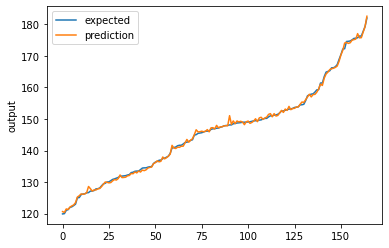

In [43]:
# Regression Lift Chart
chart_regression(nn_pred_sm.flatten(),y_test_sm,sort=True)

LSTM Model Based on Last 548 Days

In [44]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [45]:
SEQUENCE_SIZE = 5
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, test_size=0.3, random_state=42)
x_train_sm = x_train_sm[:, :, np.newaxis]
x_test_sm = x_test_sm[:, :, np.newaxis]

print("Shape of x_train: {}".format(x_train_sm.shape))
print("Shape of x_test: {}".format(x_test_sm.shape))
print("Shape of y_train: {}".format(y_train_sm.shape))
print("Shape of y_test: {}".format(y_test_sm.shape))

Shape of x_train: (383, 5, 1)
Shape of x_test: (165, 5, 1)
Shape of y_train: (383,)
Shape of y_test: (165,)


In [46]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    lstm_model_sm = Sequential()

    lstm_model_sm.add(LSTM(128,activation='relu',input_shape=(SEQUENCE_SIZE, 1),
                           return_sequences=True))
    lstm_model_sm.add(LSTM(64,activation='relu',return_sequences=True))
    lstm_model_sm.add(LSTM(32,activation='relu',return_sequences=True))
    lstm_model_sm.add(LSTM(16,activation='relu',return_sequences=False))
    lstm_model_sm.add(Dense(256,activation='relu'))
    lstm_model_sm.add(Dense(128,activation='relu'))
    lstm_model_sm.add(Dense(64,activation='relu'))
    lstm_model_sm.add(Dense(32,activation='relu'))
    lstm_model_sm.add(Dense(16,activation='relu'))
    lstm_model_sm.add(Dense(1))

    lstm_model_sm.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    lstm_model_sm.fit(x_train_sm,y_train_sm,validation_data=(x_test_sm,y_test_sm), 
                      callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2, epochs=100)  

lstm_model_sm.load_weights('lstm/best_weights.hdf5') # load weights from best model

lstm_pred_sm = lstm_model_sm.predict(x_test_sm)

Epoch 1/100
12/12 - 4s - loss: 22086.7227 - mean_absolute_error: 147.8149 - val_loss: 21454.8945 - val_mean_absolute_error: 145.7375
Epoch 2/100
12/12 - 0s - loss: 21919.9590 - mean_absolute_error: 147.2508 - val_loss: 21007.0898 - val_mean_absolute_error: 144.1933
Epoch 3/100
12/12 - 0s - loss: 18283.2812 - mean_absolute_error: 132.2891 - val_loss: 13065.8164 - val_mean_absolute_error: 102.0184
Epoch 4/100
12/12 - 0s - loss: 9466.7842 - mean_absolute_error: 88.5967 - val_loss: 6313.3140 - val_mean_absolute_error: 72.0669
Epoch 5/100
12/12 - 0s - loss: 3528.3965 - mean_absolute_error: 52.3273 - val_loss: 1649.0137 - val_mean_absolute_error: 36.2772
Epoch 6/100
12/12 - 0s - loss: 829.8893 - mean_absolute_error: 23.0187 - val_loss: 473.6788 - val_mean_absolute_error: 19.6271
Epoch 7/100
12/12 - 0s - loss: 250.8457 - mean_absolute_error: 12.3030 - val_loss: 171.8301 - val_mean_absolute_error: 11.7680
Epoch 8/100
12/12 - 0s - loss: 129.1680 - mean_absolute_error: 8.8603 - val_loss: 110.522

In [47]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(lstm_pred_sm,y_test_sm))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 1.7680974006652832


In [48]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 15:59:01 ago. (Use '!kill 4332' to kill it.)

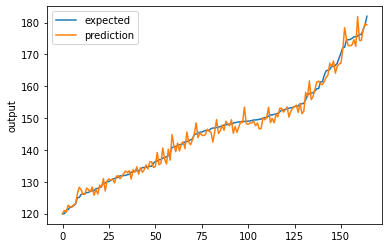

In [49]:
# Regression Lift Chart
chart_regression(lstm_pred_sm.flatten(),y_test_sm,sort=True)

CNN Model Based on Last 548 Days

In [50]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [51]:
# Define batch_size
batch_size = 32
# define input image dimensions
img_rows, img_cols = 5, 1

In [52]:
x_train_sm = x_train_sm.reshape(x_train_sm.shape[0], 5, 1, 1)
x_test_sm = x_test_sm.reshape(x_test_sm.shape[0], 5, 1, 1)
print(x_train_sm.shape)
print(x_test_sm.shape)

(383, 5, 1, 1)
(165, 5, 1, 1)


In [53]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    cnn_model_sm = Sequential()

    input_shape = (5, 1, 1)

    cnn_model_sm.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                    activation='relu',
                    input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)
    cnn_model_sm.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model_sm.add(Conv2D(16, kernel_size=(1,1), activation='relu'))
    cnn_model_sm.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_model_sm.add(Flatten())
    cnn_model_sm.add(Dense(256, activation='relu'))
    cnn_model_sm.add(Dense(128, activation='relu'))
    cnn_model_sm.add(Dense(64, activation='relu'))
    cnn_model_sm.add(Dense(32, activation='relu'))
    cnn_model_sm.add(Dense(16, activation='relu'))
    cnn_model_sm.add(Dense(1))

    cnn_model_sm.compile(loss='mean_squared_error', metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    cnn_model_sm.fit(x_train_sm, y_train_sm, batch_size=batch_size, epochs=100, verbose=2, 
                  validation_data=(x_test_sm, y_test_sm),
                  callbacks=[monitor, checkpointer,tensorboard_callback])

cnn_model_sm.load_weights('cnn/best_weights.hdf5') # load weights from best model

cnn_pred_sm = cnn_model_sm.predict(x_test_sm)

Epoch 1/100
12/12 - 1s - loss: 21968.4043 - mean_absolute_error: 147.4220 - val_loss: 21102.0098 - val_mean_absolute_error: 144.5437
Epoch 2/100
12/12 - 0s - loss: 20586.9707 - mean_absolute_error: 142.6777 - val_loss: 17827.5020 - val_mean_absolute_error: 132.7550
Epoch 3/100
12/12 - 0s - loss: 12216.2246 - mean_absolute_error: 105.5753 - val_loss: 3863.0811 - val_mean_absolute_error: 53.6801
Epoch 4/100
12/12 - 0s - loss: 3727.3059 - mean_absolute_error: 49.4272 - val_loss: 2527.4646 - val_mean_absolute_error: 42.9136
Epoch 5/100
12/12 - 0s - loss: 2200.6648 - mean_absolute_error: 39.6225 - val_loss: 1826.1687 - val_mean_absolute_error: 36.6698
Epoch 6/100
12/12 - 0s - loss: 1517.2595 - mean_absolute_error: 32.6213 - val_loss: 1295.4664 - val_mean_absolute_error: 30.8671
Epoch 7/100
12/12 - 0s - loss: 1060.8804 - mean_absolute_error: 27.3790 - val_loss: 829.9623 - val_mean_absolute_error: 24.4400
Epoch 8/100
12/12 - 0s - loss: 685.4819 - mean_absolute_error: 21.4796 - val_loss: 547.6

In [54]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(cnn_pred_sm,y_test_sm))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 1.0032490491867065


In [55]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 16:01:39 ago. (Use '!kill 4332' to kill it.)

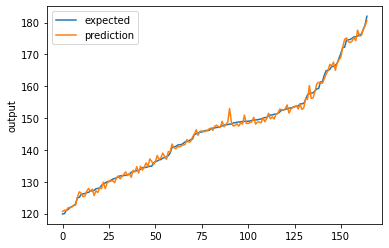

In [56]:
# Regression Lift Chart
chart_regression(cnn_pred_sm.flatten(),y_test_sm,sort=True)

LSTM Model With Bidirectional and Attention Layers Based on Last 548 Days

In [57]:
# Clear any logs from previous runs
!rd /s /q "./logs/"
#!rm -rf ./logs/ 

./logs/\fit\202303~1\train\events.out.tfevents.1678127684.JAIMES_FRAME.7364.270.v2 - Access is denied.
./logs/\fit\202303~1\VALIDA~1\events.out.tfevents.1678127685.JAIMES_FRAME.7364.1108.v2 - Access is denied.
./logs/\fit\202303~2\train\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12105.v2 - Access is denied.
./logs/\fit\202303~2\VALIDA~1\events.out.tfevents.1678127688.JAIMES_FRAME.7364.12943.v2 - Access is denied.
./logs/\fit\202303~3\train\events.out.tfevents.1678127691.JAIMES_FRAME.7364.20872.v2 - Access is denied.
./logs/\fit\202303~3\VALIDA~1\events.out.tfevents.1678127692.JAIMES_FRAME.7364.21710.v2 - Access is denied.
./logs/\fit\202303~4\train\events.out.tfevents.1678127695.JAIMES_FRAME.7364.31253.v2 - Access is denied.
./logs/\fit\202303~4\VALIDA~1\events.out.tfevents.1678127696.JAIMES_FRAME.7364.32091.v2 - Access is denied.
./logs/\fit\20CA20~1\train\events.out.tfevents.1678127698.JAIMES_FRAME.7364.39264.v2 - Access is denied.
./logs/\fit\20CA20~1\VALIDA~1\events.out.tfeve

In [58]:
SEQUENCE_SIZE = 5
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, test_size=0.3, random_state=42)
x_train_sm = x_train_sm[:, :, np.newaxis]
x_test_sm = x_test_sm[:, :, np.newaxis]

print("Shape of x_train: {}".format(x_train_sm.shape))
print("Shape of x_test: {}".format(x_test_sm.shape))
print("Shape of y_train: {}".format(y_train_sm.shape))
print("Shape of y_test: {}".format(y_test_sm.shape))

Shape of x_train: (383, 5, 1)
Shape of x_test: (165, 5, 1)
Shape of y_train: (383,)
Shape of y_test: (165,)


In [59]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    lstm_model_sm = Sequential()

    lstm_model_sm.add(Bidirectional(LSTM(32,activation='relu',input_shape=(SEQUENCE_SIZE, 1),
                           return_sequences=True)))
    lstm_model_sm.add(Bidirectional(LSTM(16,activation='relu',return_sequences=True)))
    lstm_model_sm.add(Bidirectional(LSTM(8,activation='relu',return_sequences=True)))
    lstm_model_sm.add(Attention(units=128))
    lstm_model_sm.add(Dense(256,activation='relu'))
    lstm_model_sm.add(Dense(128,activation='relu'))
    lstm_model_sm.add(Dense(64,activation='relu'))
    lstm_model_sm.add(Dense(32,activation='relu'))
    lstm_model_sm.add(Dense(16,activation='relu'))
    lstm_model_sm.add(Dense(1))

    lstm_model_sm.compile(loss='mean_squared_error',metrics="mean_absolute_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    lstm_model_sm.fit(x_train_sm,y_train_sm,validation_data=(x_test_sm,y_test_sm), 
                      callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2, epochs=100)  

lstm_model_sm.load_weights('lstm/best_weights.hdf5') # load weights from best model

lstm_pred_sm = lstm_model_sm.predict(x_test_sm)

Epoch 1/100
12/12 - 4s - loss: 22103.1328 - mean_absolute_error: 147.8705 - val_loss: 21504.4180 - val_mean_absolute_error: 145.9073
Epoch 2/100
12/12 - 0s - loss: 22077.2559 - mean_absolute_error: 147.7840 - val_loss: 21450.4297 - val_mean_absolute_error: 145.7236
Epoch 3/100
12/12 - 0s - loss: 21877.0176 - mean_absolute_error: 147.1082 - val_loss: 20837.9785 - val_mean_absolute_error: 143.6504
Epoch 4/100
12/12 - 0s - loss: 18666.9297 - mean_absolute_error: 135.4923 - val_loss: 11675.8545 - val_mean_absolute_error: 105.3003
Epoch 5/100
12/12 - 0s - loss: 6266.0811 - mean_absolute_error: 69.8632 - val_loss: 2115.7771 - val_mean_absolute_error: 41.4154
Epoch 6/100
12/12 - 0s - loss: 1365.0796 - mean_absolute_error: 31.3015 - val_loss: 271.3435 - val_mean_absolute_error: 13.6110
Epoch 7/100
12/12 - 0s - loss: 236.0084 - mean_absolute_error: 11.5620 - val_loss: 179.3416 - val_mean_absolute_error: 10.8968
Epoch 8/100
12/12 - 0s - loss: 182.0712 - mean_absolute_error: 11.1194 - val_loss: 1

In [60]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(lstm_pred_sm,y_test_sm))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 1.5600026845932007


In [61]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4332), started 8 days, 16:05:42 ago. (Use '!kill 4332' to kill it.)

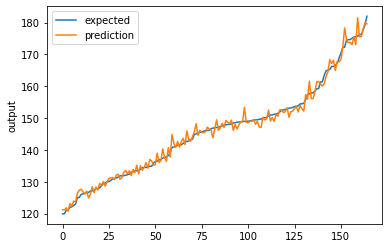

In [62]:
# Regression Lift Chart
chart_regression(lstm_pred_sm.flatten(),y_test_sm,sort=True)